In [1]:
import pandas as pd
import os
import re
import sys
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
sns.set_context("poster")
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from em_utils import *

# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/6.two_timepoints_delta"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/6.two_timepoints_deltas"
os.makedirs(output_dir, exist_ok=True)

m1_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/zachs_rerun/drift_fs/csv/all_omic_processed_data/deltas/"
test = read_data(m1_dir, "feb20_all_delta_test.csv")
train = read_data(m1_dir, "feb20_all_delta_train.csv")

In [2]:
print("Train columns :", train.columns.to_list())
print("Test columns:", test.columns.to_list())

Train columns : ['subject_id', 'randomized_group', 'age.x', 'sex', 'race', 'BMI', 'Weight', 'CRP', 'cholesterol', 'ghrelin', 'HDL', 'LDL', 'HbA1C', 'insulin', 'leptin', 'peptide_yy', 'tgcyd', 'homo_ir', 'bmi_prs', 'age.y', 'outcome_wt_fnl', 'outcome_BMI_fnl', 'Glucose', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'N10-formyl-tetrahydrofolate_biosynthesis', 'homolactic_fermentation', 'glycolysis_III_(from_glucose)', 'superpathway_of_arginine_and_polyamine_biosynthesis', 'arginine,_ornithine_and_proline_interconversion', 'L-arginine_biosynthesis_I_(via_L-ornithine)', 'L-arginine_biosynthesis_II_(acetyl_cycle)', 'chorismate_biosynthesis_I', 'superpathway_of_L-aspartate_and_L-asparagine_biosynthesis', 'biotin_biosynthesis_I', 'superpathway_of_branched_amino_acid_biosynthesis', 'Calvin-Benson-Bassham_cycle', 'pyruvate_fermentation_to_butanoate', 'coenzyme_A_biosynthesis_I', 'adenosylcobalamin_salvage_from_cobinamide_I', 'reductive_acetyl_coen

In [4]:
columns_to_drop = ['Weight', 'CRP', 'ghrelin','leptin', 'age.x''peptide_yy', 'tgcyd', 'bmi_prs', 'age.y', 
                   'outcome_wt_fnl', 'outcome_BMI_fnl', 'Glucose','HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid']
train = train.drop([col for col in columns_to_drop if col in train.columns], axis=1)
test = test.drop([col for col in columns_to_drop if col in test.columns], axis=1)

print("test shape = ", test.shape)
print("train shape = ", train.shape)

test = test.dropna()
train = train.dropna()

print("test shape = ", test.shape)
print("train shape = ", train.shape)

test shape =  (60, 532)
train shape =  (222, 532)
test shape =  (60, 532)
train shape =  (222, 532)


In [5]:
print("---------- Select predictors for training set ----------")
train_set = train
X = train_set.drop(['BMI', 'subject_id', 'range'], axis=1)
Y = train_set[['BMI']]
Y = Y['BMI'].to_numpy() # Convert Y to numeric array
clusters_train = train_set['subject_id'].to_numpy() # Get ID variables
Z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones

print("X shape: ", X.shape)
print("X data: \n", X)

print("---------- Select predictors for test set ----------")
test_set = test
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)
X_new = X_new[X.columns]  # Reorder and select columns to match training set
X_new = X_new.astype(X.dtypes)  # Ensure data types match

Y_new = test_set['BMI'].to_numpy()  # Convert Y to numeric array
clusters_new = pd.Series(test_set['subject_id'])  # Convert to pandas Series
Z_new = np.ones((len(X_new), 1))

print("X_new shape: ", X_new.shape)
print("X_new data: \n", X_new)

---------- Select predictors for training set ----------
X shape:  (222, 529)
X data: 
      randomized_group       sex      race  cholesterol       HDL       LDL  \
0             0.00000  0.000000  5.659933    -0.365359 -0.678155  0.051917   
1             0.00000  0.000000  5.659933    -1.507106 -0.847693 -0.363416   
2             1.99622  0.000000  2.263973    -0.959067  1.017232 -0.986416   
3             0.00000  0.000000  7.923906     0.548039  0.339077  0.519166   
4             0.00000  0.000000  5.659933    -1.278757 -0.508616 -1.453666   
..                ...       ...       ...          ...       ...       ...   
217           1.99622  2.164501  2.263973     1.050407  1.695387  0.674916   
218           1.99622  2.164501  5.659933     0.137010 -0.169539  0.934499   
219           1.99622  0.000000  5.659933     0.593708 -0.169539  0.830666   
220           0.00000  0.000000  5.659933    -0.045670  0.339077 -0.103833   
221           1.99622  2.164501  2.263973    -0.319689

### Read in fine tuning params

In [6]:
df = pd.read_csv(os.path.join(df_dir, 'feb20_2times_omic_deltas_BMI.csv'))

# the line below filters out certain folds
# df = df[df['n_splits'] == 5]

# Find the row with the lowest mean_mse_score
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
print("First 5 columns for the lowest mean_mse_score:")
print(lowest_mse_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
print("First 5 columns for the lowest mean_prev_score:")
print(lowest_prev_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
print("First 5 columns for the lowest mean_ptev_score:")
print(lowest_ptev_row.iloc[:5])

# Find the row with the highest oob_score
highest_oob_row = df.loc[df['oob_score'].idxmax()]
print("\nFirst 5 columns for the highest oob_score:")
print(highest_oob_row.iloc[:5])

First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits               5.00
Name: 19, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits               3.00
Name: 0, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits              10.00
Name: 5, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits                5.00
Name: 40, dtype: float64


### Take a look at all the parameters 

In [7]:
# Extract the rows for the parameter grids
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
highest_oob_row = df.loc[df['oob_score'].idxmax()]

# Create parameter grids from the extracted rows
best_mse_param_grid = {
    'n_estimators': [int(lowest_mse_row['n_estimators'])],
    #'max_depth': [int(lowest_mse_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_mse_row['max_depth']) else int(lowest_mse_row['max_depth'])],
    'min_samples_split': [float(lowest_mse_row['min_samples_split'])],
    #'min_samples_split': [float(lowest_mse_row['min_samples_split']) if lowest_mse_row['min_samples_split'] != 0 else 0.0],  # Convert 0 to 0.0
    'max_iter': [int(lowest_mse_row['max_iter'])],
    'n_splits': [int(lowest_mse_row['n_splits'])]
}
print("Best MSE Parameter Grid:")
print("n_estimators:", best_mse_param_grid['n_estimators'][0])
print("max_depth:", best_mse_param_grid['max_depth'][0])
print("min_samples_split:", best_mse_param_grid['min_samples_split'][0])
print("max_iter:", best_mse_param_grid['max_iter'][0])
print("n_splits:", best_mse_param_grid['n_splits'][0])

lowest_prev_param_grid = {
    'n_estimators': [int(lowest_prev_row['n_estimators'])],
    #'max_depth': [int(lowest_prev_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_prev_row['max_depth']) else int(lowest_prev_row['max_depth'])],
    'min_samples_split': [float(lowest_prev_row['min_samples_split'])],
    'max_iter': [int(lowest_prev_row['max_iter'])],
    'n_splits': [int(lowest_prev_row['n_splits'])]
}
print("\nLowest Prev Parameter Grid:")
print("n_estimators:", lowest_prev_param_grid['n_estimators'][0])
print("max_depth:", lowest_prev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_prev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_prev_param_grid['max_iter'][0])
print("n_splits:", lowest_prev_param_grid['n_splits'][0])

lowest_ptev_param_grid = {
    'n_estimators': [int(lowest_ptev_row['n_estimators'])],
    #'max_depth': [int(lowest_ptev_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_ptev_row['max_depth']) else int(lowest_ptev_row['max_depth'])],
    'min_samples_split': [float(lowest_ptev_row['min_samples_split'])],
    'max_iter': [int(lowest_ptev_row['max_iter'])],
    'n_splits': [int(lowest_ptev_row['n_splits'])]
}
print("\nLowest PTEV Parameter Grid:")
print("n_estimators:", lowest_ptev_param_grid['n_estimators'][0])
print("max_depth:", lowest_ptev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_ptev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_ptev_param_grid['max_iter'][0])
print("n_splits:", lowest_ptev_param_grid['n_splits'][0])

highest_oob_param_grid = {
    'n_estimators': [int(highest_oob_row['n_estimators'])],
    'max_depth': [None if pd.isna(highest_oob_row['max_depth']) else int(highest_oob_row['max_depth'])],
    'min_samples_split': [float(highest_oob_row['min_samples_split'])],
    'max_iter': [int(highest_oob_row['max_iter'])],
    'n_splits': [int(highest_oob_row['n_splits'])]
}
print("\Highest OOB Parameter Grid:")
print("n_estimators:", highest_oob_row['n_estimators'])
print("max_depth:", highest_oob_row['max_depth'])
print("min_samples_split:", highest_oob_row['min_samples_split'])
print("max_iter:", highest_oob_row['max_iter'])
print("n_splits:", highest_oob_row['n_splits'])

Best MSE Parameter Grid:
n_estimators: 500
max_depth: None
min_samples_split: 0.05
max_iter: 2
n_splits: 5

Lowest Prev Parameter Grid:
n_estimators: 100
max_depth: None
min_samples_split: 0.05
max_iter: 2
n_splits: 3

Lowest PTEV Parameter Grid:
n_estimators: 100
max_depth: None
min_samples_split: 0.05
max_iter: 10
n_splits: 10
\Highest OOB Parameter Grid:
n_estimators: 1000.0
max_depth: nan
min_samples_split: 0.05
max_iter: 10.0
n_splits: 5.0


<>:61: SyntaxWarning: invalid escape sequence '\H'
<>:61: SyntaxWarning: invalid escape sequence '\H'
/var/folders/4l/kqxc4rwn4lj10fzv9hw4xxsr0000gn/T/ipykernel_53008/2937010470.py:61: SyntaxWarning: invalid escape sequence '\H'
  print("\Highest OOB Parameter Grid:")


### Set up different merfs 

In [8]:
# Create MERF models for each parameter grid
mse_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = best_mse_param_grid['n_estimators'][0], 
                                max_depth = best_mse_param_grid['max_depth'][0], 
                                min_samples_split = best_mse_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = best_mse_param_grid['max_iter'][0])

prev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_prev_param_grid['n_estimators'][0], 
                                max_depth = lowest_prev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_prev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_prev_param_grid['max_iter'][0])

ptev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_ptev_param_grid['n_estimators'][0], 
                                max_depth = lowest_ptev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_ptev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_ptev_param_grid['max_iter'][0])

oob_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = highest_oob_param_grid['n_estimators'][0], 
                                max_depth = highest_oob_param_grid['max_depth'][0], 
                                min_samples_split = highest_oob_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = highest_oob_param_grid['max_iter'][0])

## run Merfs 

In [9]:
print("---------- RUN MERF RAW WITH TUNING PARAMETERS 🌱 ----------")
mrf_mse = mse_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_prev = prev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_ptev = ptev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_oob = oob_merf.fit(X.select_dtypes(include=[np.number]), 
                Z, 
                pd.Series(clusters_train), 
                Y)

---------- RUN MERF RAW WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -230.58605172330357 at iteration 1.
INFO     [merf.py:307] Training GLL is -340.2269765015591 at iteration 2.
INFO     [merf.py:307] Training GLL is -228.32849902493183 at iteration 1.
INFO     [merf.py:307] Training GLL is -344.64819654236766 at iteration 2.
INFO     [merf.py:307] Training GLL is -224.85212338707274 at iteration 1.
INFO     [merf.py:307] Training GLL is -335.1323700857258 at iteration 2.
INFO     [merf.py:307] Training GLL is -357.6218912136299 at iteration 3.
INFO     [merf.py:307] Training GLL is -384.24675067762047 at iteration 4.
INFO     [merf.py:307] Training GLL is -398.6194397259096 at iteration 5.
INFO     [merf.py:307] Training GLL is -402.43403973029837 at iteration 6.
INFO     [merf.py:307] Training GLL is -408.65429620280486 at iteration 7.
INFO     [merf.py:307] Training GLL is -409.11422426518567 at iteration 8.
INFO     [merf.py:307] Training GLL is -412.5542255321682 at iteration 9.
INFO     [merf.py:307] Trainin

### Make predictions using fitted models 

In [10]:
# Predict using the fitted model
clusters_new = pd.Series(test_set['subject_id'])
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)
y_hat_new_mse = mrf_mse.predict(X_new, Z_new, clusters_new)
forest_mse = mrf_mse.trained_fe_model
oob_score_mse = round(forest_mse.oob_score_*100, 1)

y_hat_new_prev = mrf_prev.predict(X_new, Z_new, clusters_new)
forest_prev = mrf_prev.trained_fe_model
oob_score_prev = round(forest_prev.oob_score_*100, 1)

y_hat_new_ptev = mrf_ptev.predict(X_new, Z_new, clusters_new)
forest_ptev = mrf_ptev.trained_fe_model
oob_score_ptev = round(forest_ptev.oob_score_*100, 1)

y_hat_new_oob = mrf_oob.predict(X_new, Z_new, clusters_new)
forest_oob = mrf_oob.trained_fe_model
oob_score_tuned = round(forest_oob.oob_score_*100, 1)

### Plot predicted vs actual

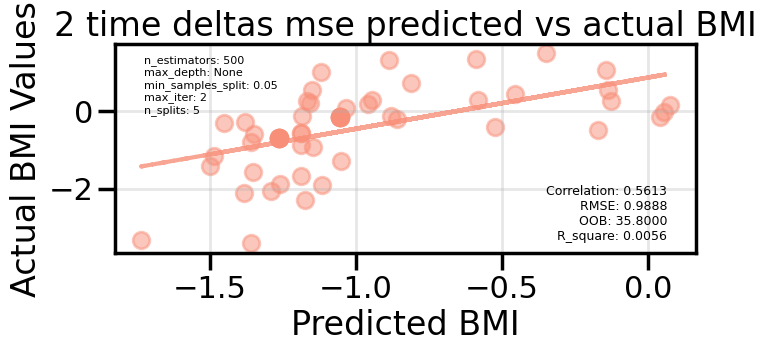

In [11]:
plot_predicted_vs_actual(y_hat_new_mse, Y_new,
                         output_dir, 'feb20_all_predicted_vs_actual_mse_tuned.png', 
                         best_mse_param_grid, oob_score_mse, '#F88F79', '2 time deltas mse predicted vs actual BMI')

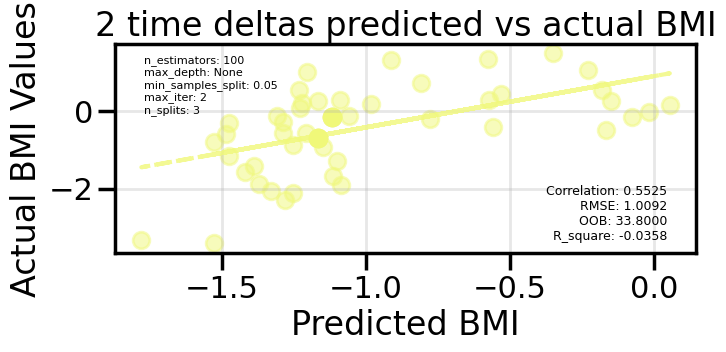

In [12]:
plot_predicted_vs_actual(y_hat_new_prev, Y_new,
                         output_dir, 'Feb20_all_predicted_vs_actual_prev_tuned.png', 
                         lowest_prev_param_grid, oob_score_prev, '#F0F879', '2 time deltas predicted vs actual BMI')

Correlation between actual and predicted values: 0.6015
Root Mean Squared Error: 0.9179
R-squared Score: 0.1431


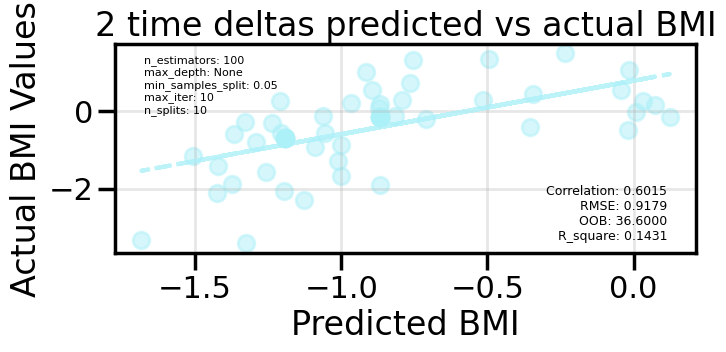

In [13]:
calculate_metrics(Y_new, y_hat_new_ptev) #(Y_true, Y_pred)
plot_predicted_vs_actual(y_hat_new_ptev, Y_new,
                         output_dir, 'feb20_all_predicted_vs_actual_ptev_tuned.png', 
                         lowest_ptev_param_grid, oob_score_ptev, '#ACF0F8', '2 time deltas predicted vs actual BMI')

Correlation between actual and predicted values: 0.5644
Root Mean Squared Error: 0.9555
R-squared Score: 0.0715


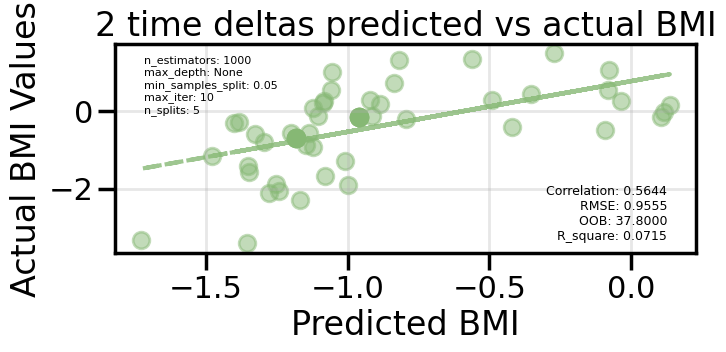

In [14]:
calculate_metrics(Y_new, y_hat_new_oob) #(Y_true, Y_pred)
plot_predicted_vs_actual(y_hat_new_oob, Y_new,
                         output_dir, 'feb20_all_predicted_vs_actual_oob_tuned.png', 
                         highest_oob_param_grid, oob_score_tuned, '#86B874', '2 time deltas predicted vs actual BMI')

### Look at feature importances 

Top 20 ft imp for best MSE parameters:
randomized_group: 0.0014780183696756334
sex: 0.0008949177317153057
race: 0.02101867021334818
cholesterol: 0.019373914547612708
HDL: 0.012784788148995604
LDL: 0.008483472804274675
HbA1C: 0.0054886308909822485
insulin: 0.06466139621479702
peptide_yy: 0.02755880813127365
homo_ir: 0.2925076693866132
N10-formyl-tetrahydrofolate_biosynthesis: 7.608680189848173e-05
homolactic_fermentation: 0.0008232183671973344
glycolysis_III_(from_glucose): 7.260834039051923e-05
superpathway_of_arginine_and_polyamine_biosynthesis: 0.0004960680038966448
arginine,_ornithine_and_proline_interconversion: 0.0006924095281013656
L-arginine_biosynthesis_I_(via_L-ornithine): 1.3197439287343417e-06
L-arginine_biosynthesis_II_(acetyl_cycle): 2.6847564011889342e-05
chorismate_biosynthesis_I: 0.0
superpathway_of_L-aspartate_and_L-asparagine_biosynthesis: 0.00024703468739663124
biotin_biosynthesis_I: 0.0003501265628116323


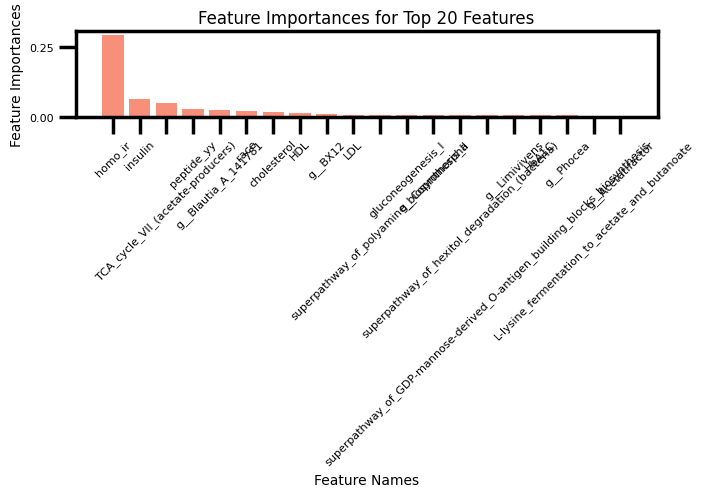

In [15]:
# mse
mse_forest = mrf_mse.trained_fe_model
mse_feature_names = mse_forest.feature_names_in_
mse_feature_importances = mse_forest.feature_importances_

print("Top 20 ft imp for best MSE parameters:")
for name, importance in zip(mse_feature_names[:20], 
                            mse_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(mse_feature_names, mse_feature_importances, 
                         output_dir, 'feb20_deltas_2time_mse_feature_importances_all', '#F88F79')

Top 20 ft imp for best PREV parameters:
randomized_group: 0.001545300758107345
sex: 0.0010775220313853189
race: 0.021977137651848753
cholesterol: 0.02359638203940823
HDL: 0.011060741506249389
LDL: 0.007324058632101221
HbA1C: 0.004188535970897194
insulin: 0.04293862255575813
peptide_yy: 0.0321403712468297
homo_ir: 0.314933992441412
N10-formyl-tetrahydrofolate_biosynthesis: 0.0
homolactic_fermentation: 0.0
glycolysis_III_(from_glucose): 0.0
superpathway_of_arginine_and_polyamine_biosynthesis: 0.00022283582518295702
arginine,_ornithine_and_proline_interconversion: 0.00255607886811085
L-arginine_biosynthesis_I_(via_L-ornithine): 0.0
L-arginine_biosynthesis_II_(acetyl_cycle): 0.0
chorismate_biosynthesis_I: 0.0
superpathway_of_L-aspartate_and_L-asparagine_biosynthesis: 0.0011899376342441067
biotin_biosynthesis_I: 0.0


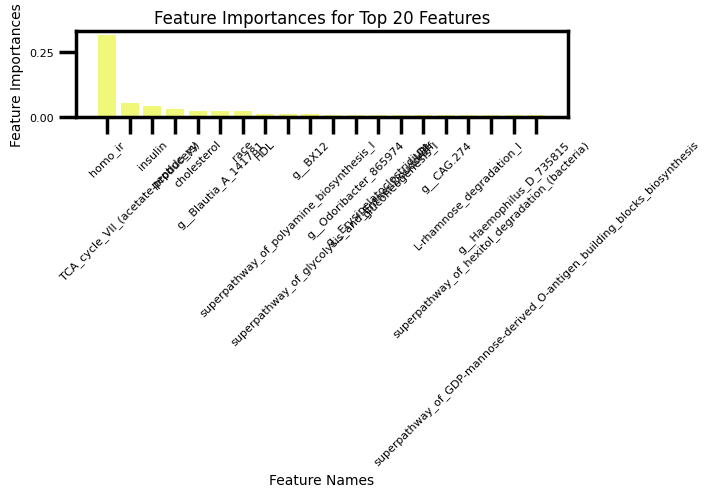

In [16]:
prev_forest = prev_merf.trained_fe_model
prev_feature_names = prev_forest.feature_names_in_
prev_feature_importances = prev_forest.feature_importances_

print("Top 20 ft imp for best PREV parameters:")
for name, importance in zip(prev_feature_names[:20], 
                            prev_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(prev_feature_names, prev_feature_importances, 
                         output_dir, 'feb20_deltas_2time_prev_feature_importances_all', '#F0F879')

Top 20 feature importances for best PTEV parameters:
randomized_group: 0.0012529120116573712
sex: 0.002073179471436152
race: 0.014513925821373208
cholesterol: 0.029593471062226283
HDL: 0.012251479650856984
LDL: 0.010633234636844013
HbA1C: 0.0057213752735941715
insulin: 0.04889357392091158
peptide_yy: 0.025241610382411062
homo_ir: 0.30054864142349674
N10-formyl-tetrahydrofolate_biosynthesis: 2.2791097709047273e-05
homolactic_fermentation: 0.00044212551346916153
glycolysis_III_(from_glucose): 0.0
superpathway_of_arginine_and_polyamine_biosynthesis: 0.001191127907465938
arginine,_ornithine_and_proline_interconversion: 0.0007727627998986342
L-arginine_biosynthesis_I_(via_L-ornithine): 0.0
L-arginine_biosynthesis_II_(acetyl_cycle): 0.0
chorismate_biosynthesis_I: 0.00035311330562189997
superpathway_of_L-aspartate_and_L-asparagine_biosynthesis: 3.5417174817746986e-06
biotin_biosynthesis_I: 0.0009162026737887071


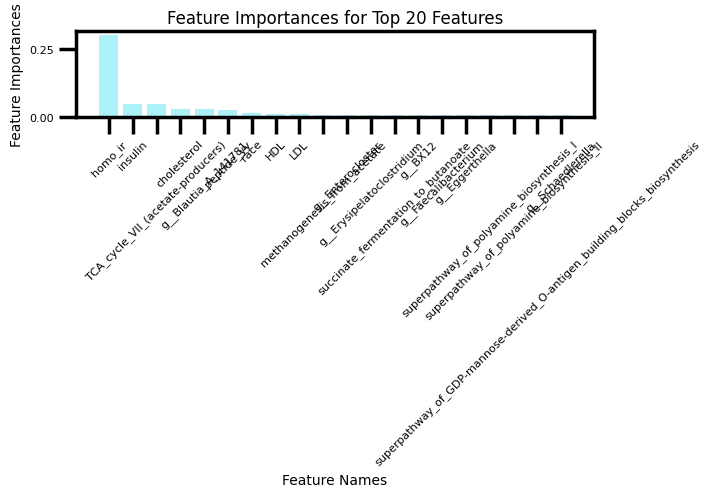

In [17]:
ptev_forest = ptev_merf.trained_fe_model
ptev_feature_names = ptev_forest.feature_names_in_
ptev_feature_importances = ptev_forest.feature_importances_

print("Top 20 feature importances for best PTEV parameters:")
for name, importance in zip(ptev_feature_names[:20], 
                            ptev_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(ptev_feature_names, ptev_feature_importances, 
                         output_dir, 'feb20__ptev_feature_importances_all', '#ACF0F8')

Top 20 ft imp for best OOB parameters:
randomized_group: 0.0015681166742402526
sex: 0.0013301071012352414
race: 0.01760737340700868
cholesterol: 0.021003633315554385
HDL: 0.012054670611044264
LDL: 0.008799928599179743
HbA1C: 0.005892269071271248
insulin: 0.05539757189628129
peptide_yy: 0.03216803121117476
homo_ir: 0.3024580346997493
N10-formyl-tetrahydrofolate_biosynthesis: 3.5880596016058795e-05
homolactic_fermentation: 0.00019182303415633006
glycolysis_III_(from_glucose): 8.504613714112507e-06
superpathway_of_arginine_and_polyamine_biosynthesis: 0.0009135521104715984
arginine,_ornithine_and_proline_interconversion: 0.0009460762550242859
L-arginine_biosynthesis_I_(via_L-ornithine): 1.552244067044176e-05
L-arginine_biosynthesis_II_(acetyl_cycle): 0.00010720635806365432
chorismate_biosynthesis_I: 3.078720360980649e-05
superpathway_of_L-aspartate_and_L-asparagine_biosynthesis: 0.00038133733019390616
biotin_biosynthesis_I: 0.0005558375199856306


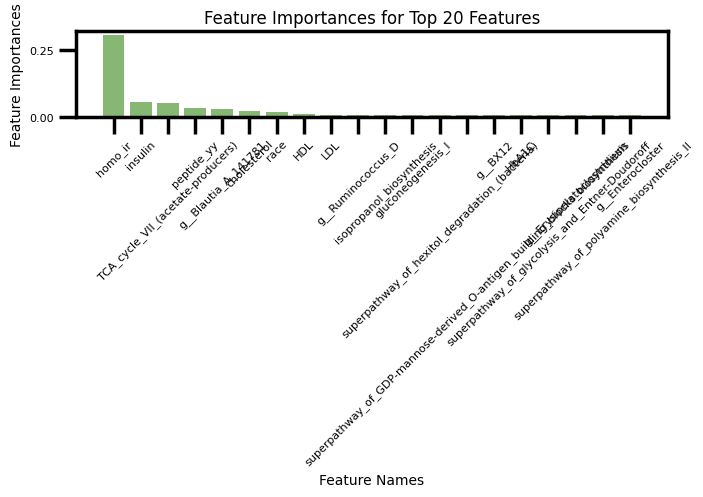

In [18]:
oob_forest = oob_merf.trained_fe_model
oob_feature_names = oob_forest.feature_names_in_
oob_feature_importances = oob_forest.feature_importances_

print("Top 20 ft imp for best OOB parameters:")
for name, importance in zip(oob_feature_names[:20], 
                            oob_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(oob_feature_names, oob_feature_importances, 
                         output_dir, 'feb20_deltas_2time_oob_feature_importances_all', '#86B874')

### Make merged plots 

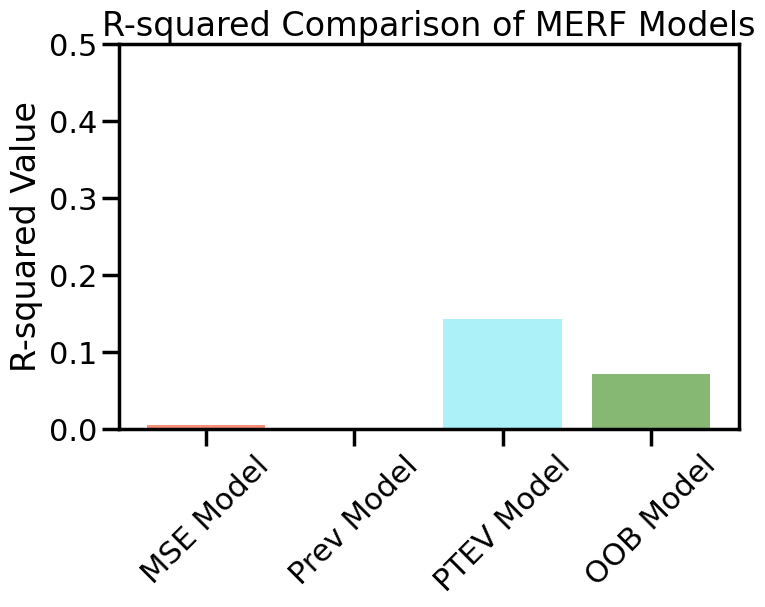

In [19]:
### Calculate R-squared values for each model
from sklearn.metrics import r2_score
color_palette = ['#F88F79', '#F0F879', '#ACF0F8', '#86B874']
# Calculate R-squared for each model
r2_mse = r2_score(Y_new, y_hat_new_mse)
r2_prev = r2_score(Y_new, y_hat_new_prev)
r2_ptev = r2_score(Y_new, y_hat_new_ptev)
r2_oob = r2_score(Y_new, y_hat_new_oob)

# Store R-squared values in a dictionary for plotting
r2_values = {
    'MSE Model': r2_mse,
    'Prev Model': r2_prev,
    'PTEV Model': r2_ptev,
    'OOB Model': r2_oob
}

# Plot R-squared values
plt.figure(figsize=(8, 5))
plt.bar(r2_values.keys(), 
        r2_values.values(), 
        color=color_palette)
plt.ylabel('R-squared Value')
plt.title('R-squared Comparison of MERF Models')
plt.ylim(0, 0.5)
plt.xticks(rotation=45)
plt.savefig(os.path.join(output_dir, 
                         'feb20_r_squared_comparison_merf_models.png'), 
                         dpi=300, bbox_inches='tight')
plt.show()

/var/folders/4l/kqxc4rwn4lj10fzv9hw4xxsr0000gn/T/ipykernel_53008/3344742276.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


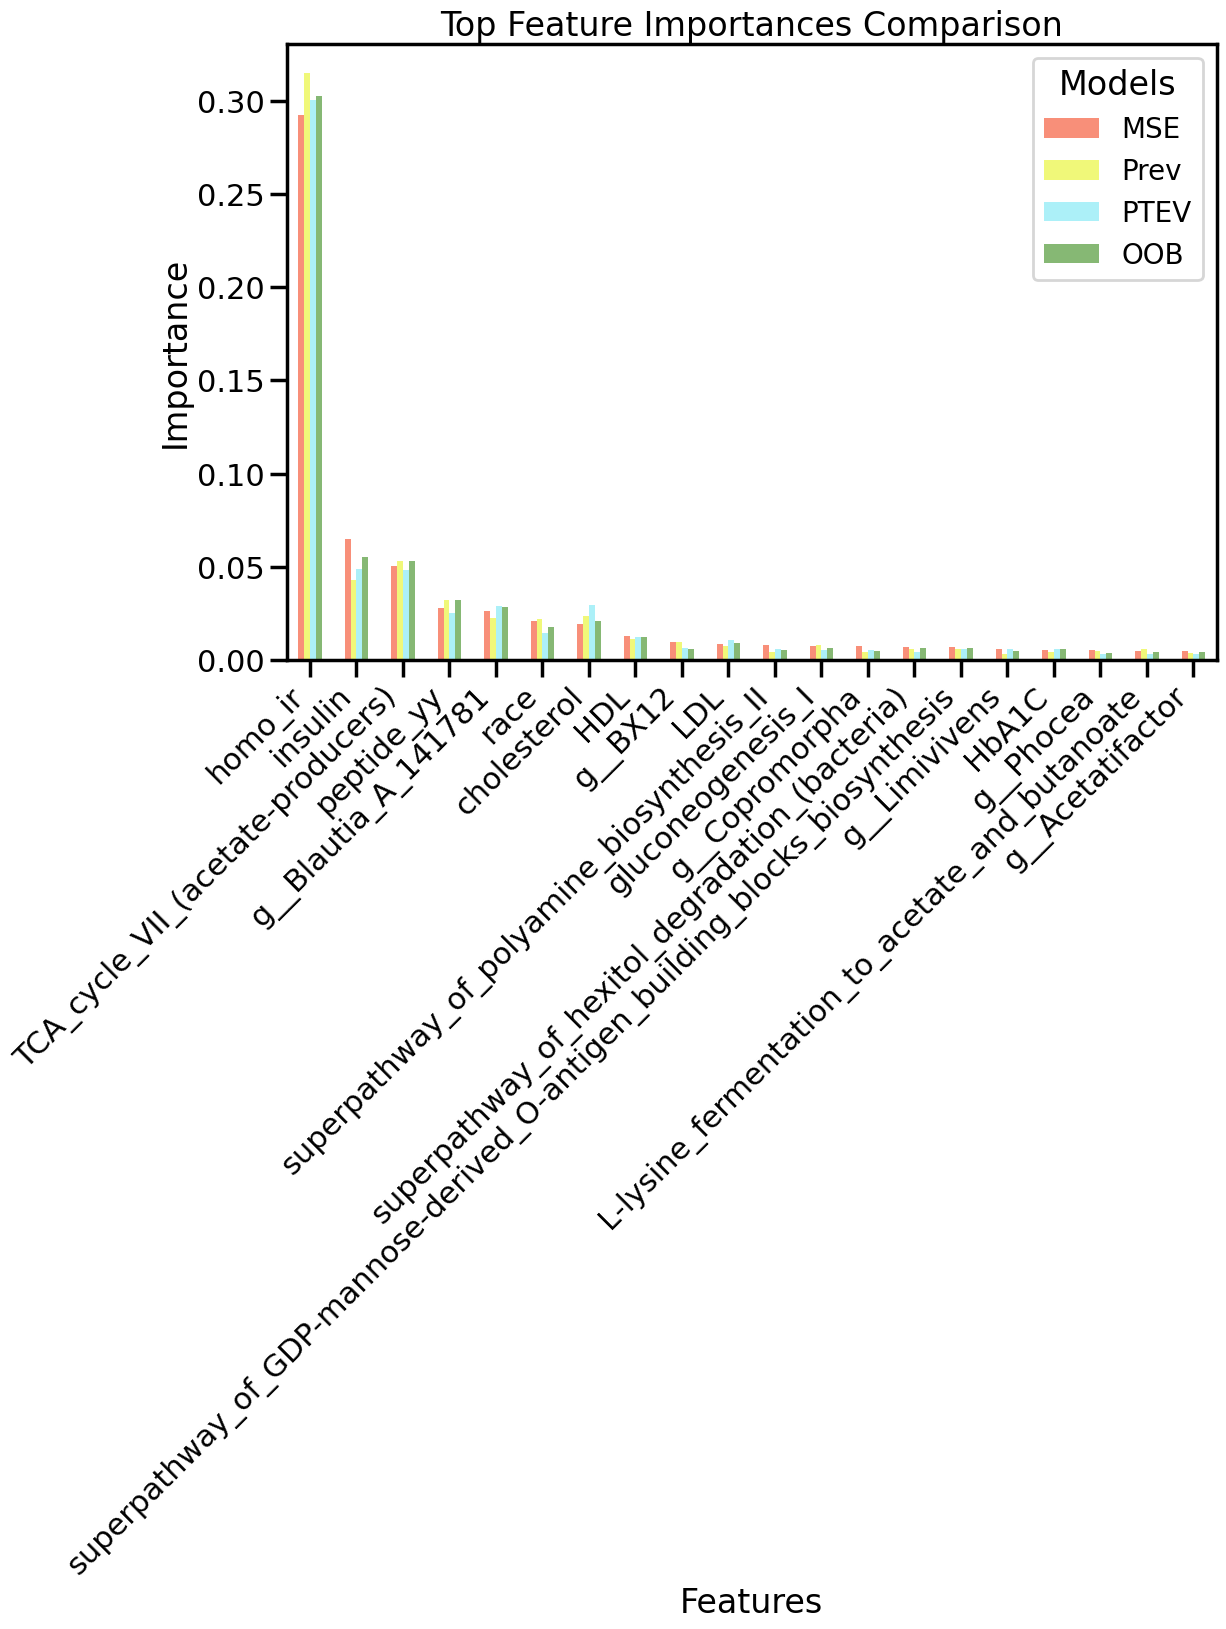

In [20]:
### Compare top feature importances between models
color_palette = ['#F88F79', '#F0F879', '#ACF0F8', '#86B874']
importances = {
    'MSE': mse_feature_importances,
    'Prev': prev_feature_importances,
    'PTEV': ptev_feature_importances,
    'OOB': oob_feature_importances
}

# Create a DataFrame for easier plotting
importances_df = pd.DataFrame(importances, index=mse_feature_names)

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values(by=importances_df.columns.tolist(), ascending=False)

# Plot top feature importances
top_n = 20  # Number of top features to display
importances_df.head(top_n).plot(kind='bar', 
                                figsize=(12, 8),
                                color=color_palette)
plt.title('Top Feature Importances Comparison')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')  # Adjusted rotation and horizontal alignment to reduce overlap
plt.legend(title='Models', 
           loc='upper right', 
           fontsize='small')  # Adjusted legend position to top right corner and made it smaller
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 
                         'feb20_top_feature_importances_comparison.png'), 
                         dpi=300, bbox_inches='tight')
plt.show()